In [1]:
import gensim
import pandas as pd
import gensim.downloader
import src.utils as utils
from nltk.corpus import stopwords
import numpy as np

stop_words = set(stopwords.words("english"))

from pymorphy3 import MorphAnalyzer

analyzer = MorphAnalyzer()
from sklearn.feature_extraction.text import CountVectorizer
from src.transform import Normalizer, LengthScaler, ToArray
from sklearn.pipeline import Pipeline

import faiss

%load_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shaenazar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# pip install faiss-cpu

In [3]:
def build_flat(dim, build_data):
    index = faiss.IndexIVFFlat(
        faiss.IndexFlatL2(dim), dim, 1024, faiss.METRIC_INNER_PRODUCT
    )
    index.train(build_data)
    index.add(build_data)

    return index


def search_flat(index, query_data, k):
    distances, labels = index.search(query_data, k)
    return distances, labels

In [2]:
data = pd.read_json("data/jailbreak.json")
normalizer = Normalizer()
data["jailbreak"] = normalizer.transform(data.jailbreak)

In [56]:
char_vectorizer = CountVectorizer(analyzer="char", ngram_range=(1, 2))

char_vectorizer.fit_transform(data.jailbreak).toarray().shape

(104, 494)

In [ ]:
w2v_model = gensim.downloader.load('glove-wiki-gigaword-50')
utils.save_model_compressed(w2v_model, "w2v_model", 9)

# w2v_model = utils.load_model("w2v_model")

In [51]:
corpus = w2v_model.key_to_index.keys()

In [52]:
import string

etalon = set(string.ascii_lowercase)
metalon = set("aeiouy")

def in_english(line):
    return np.all(np.vectorize(lambda x: x in etalon)(list(line)))

corpus = [x for x in corpus if (in_english(x) and x not in stop_words and len(x) > 2 and len(metalon & set(x)) > 0)]

In [53]:
len(corpus)

311413

In [54]:
lscaler = LengthScaler()

pipe = Pipeline([("vectorizer", char_vectorizer), ("lscaler", lscaler)])

X = pipe.transform(corpus)

In [49]:
dog = pipe.transform(["dog", "transformer"])

dog

array([[0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.33333333, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.09090909, 0.        , 0.        , 0.        ,
        0.09090909, 0.09090909, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.09090909, 0.09090909,
        0.09090909, 0.        , 0.        , 0.27272727, 0.09090909,
        0.09090909, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]])

In [55]:
len(char_vectorizer.vocabulary_)

27

In [12]:
index = build_flat(494, X)

In [49]:
utils.save_model_compressed(index, "index.pt", 9)

In [57]:
utils.save_model(pipe, "char_grams.pt")
utils.save_model(corpus, "w2v_corpus.pt")

In [58]:
corpus = utils.load_model("corpus.pt")

In [63]:
X = w2v_model[corpus]

In [60]:
from sklearnex import patch_sklearn

from openTSNE import TSNE

import numpy as np
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [68]:
tsne = TSNE(
    perplexity=30,
    metric="cosine",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

X_scaled = tsne.fit(X[np.random.choice(1000, 20000, replace=True)])

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, metric='cosine', n_jobs=8, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 8.32 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.46 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.20 seconds
===> Running optimization with exaggeration=12.00, lr=1666.67 for 250 iterations...
Iteration   50, KL divergence 3.8552, 50 iterations in 4.2010 sec
Iteration  100, KL divergence 3.5135, 50 iterations in 4.9867 sec
Iteration  150, KL divergence 3.1363, 50 iterations in 5.1395 sec
Iteration  200, KL divergence 2.9060, 50 iterations in 6.2362 sec
Iteration  250, KL divergence 2.7439, 50 iterations in 6.2877 sec
   --> Time elapsed: 26.85 seconds
===> Running optimization

In [69]:
import matplotlib.pyplot as plt

/home/shaenazar/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [82]:
from sklearn.cluster import KMeans

kmeans = KMeans(40)

In [84]:
kmeans.predict(X)

array([35, 38, 38, ..., 37, 30,  2], dtype=int32)

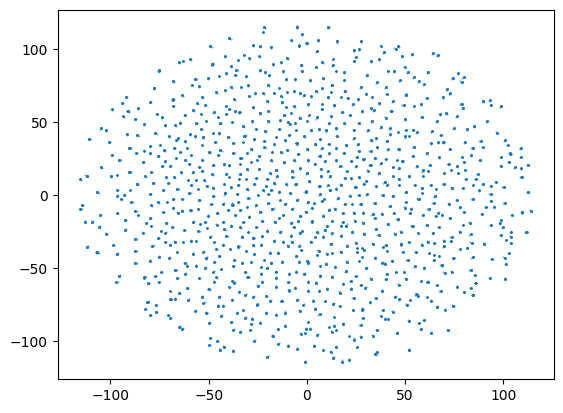

In [71]:
plt.scatter(*(X_scaled.T), s=0.1)